## Import des librairies

In [1]:
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import numpy as np
from statistics import *
import csv
from os import path

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

import plotly
import plotly.express as px

## Import des données

In [2]:
repository = "C:/Users/Mathilde Niay/Desktop/Kinan/test WMCS/"
repository_bit = repository + "BTC-EUR.csv" 
repository_eth = repository + "ETH-EUR.csv"

data_bit = pd.read_csv(repository_bit)
data_eth = pd.read_csv(repository_eth)
data_eth

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-09-18,187.862411,196.486679,188.634079,191.664566,191.664566,8.336536e+09
1,2019-09-19,191.532379,201.739441,185.277878,200.299454,200.299454,9.613097e+09
2,2019-09-20,200.108246,201.092926,195.249847,197.872787,197.872787,7.285106e+09
3,2019-09-21,197.734238,200.511932,195.105133,195.573410,195.573410,7.026783e+09
4,2019-09-22,195.546509,196.099777,188.439224,191.978912,191.978912,7.090220e+09
...,...,...,...,...,...,...,...
575,2021-04-15,2032.834351,2125.931396,2010.377930,2104.623291,2104.623291,2.700678e+10
576,2021-04-16,2102.522705,2130.138672,1934.994629,2029.607666,2029.607666,3.020854e+10
577,2021-04-17,2027.967285,2084.290283,1947.666016,1957.023560,1957.023560,2.699879e+10
578,2021-04-18,1958.323364,1974.187256,1678.942139,1869.134644,1869.134644,4.235697e+10


## Traitement préalable des données

In [3]:
data_bit["Date"] = pd.to_datetime(data_bit["Date"])
data_eth["Date"] = pd.to_datetime(data_eth["Date"])

data_bit["Crypto"] = "Bitcoin"
data_eth["Crypto"] = "Ethereum"

In [4]:
### traitement des valeurs nulles
# 2 solutions :
# - obtenir valeurs sur un autre site, mais vérifier fiabilité
# - enlever jours avec valeurs nulles (solution utilisée)

def null_values(df):
    l_null = []
    for i in df.columns:
        l_aux = df[df[i].isnull()]["Date"]
        l_null.extend(l_aux)
    l_null = list(set(l_null))
    print(l_null)
    return(df[~(df["Date"].isin(l_null))])

data_bit = null_values(data_bit)
data_eth = null_values(data_eth)
data_all = pd.concat([data_bit, data_eth]).reset_index()

[Timestamp('2020-10-13 00:00:00'), Timestamp('2020-10-12 00:00:00'), Timestamp('2020-04-17 00:00:00'), Timestamp('2020-10-09 00:00:00')]
[Timestamp('2020-10-13 00:00:00'), Timestamp('2020-10-12 00:00:00'), Timestamp('2020-04-17 00:00:00'), Timestamp('2020-10-09 00:00:00')]


Date


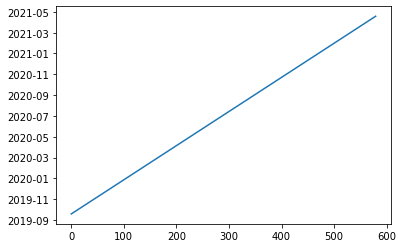

Open


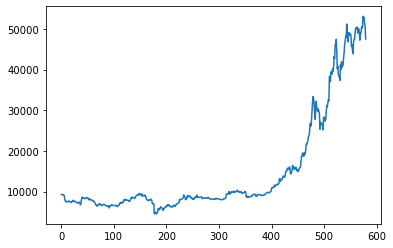

High


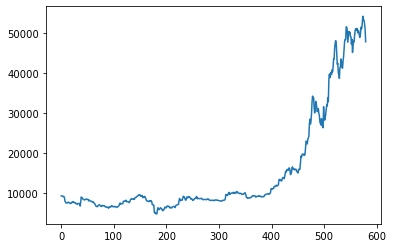

Low


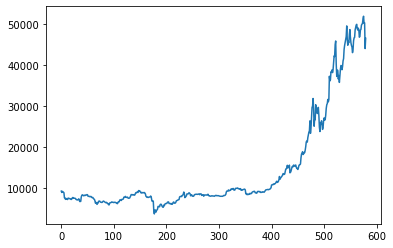

Close


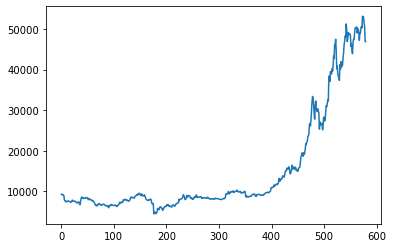

Adj Close


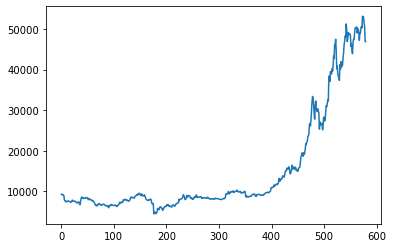

Volume


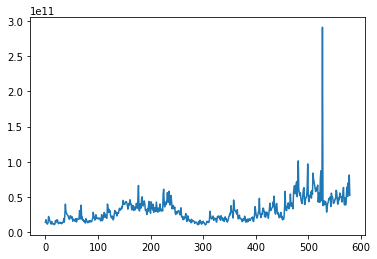

Crypto


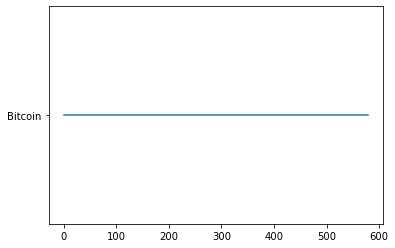

Date


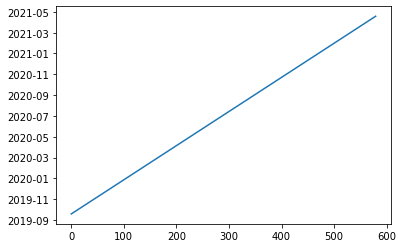

Open


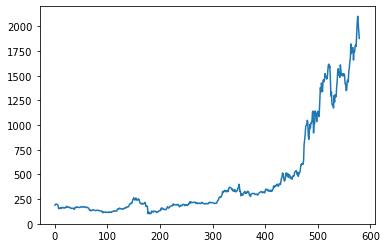

High


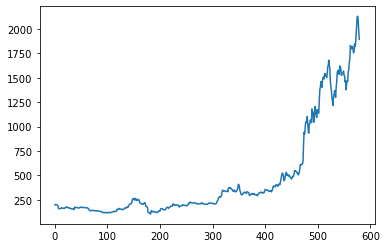

Low


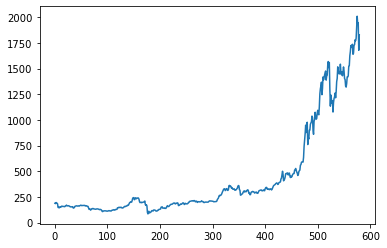

Close


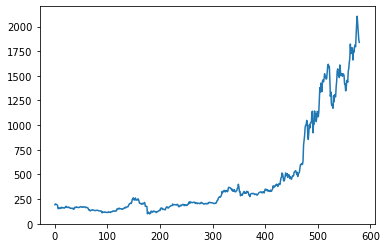

Adj Close


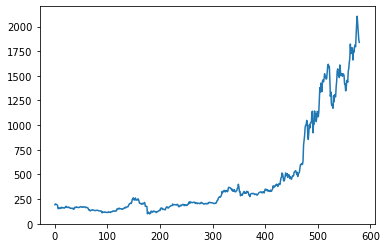

Volume


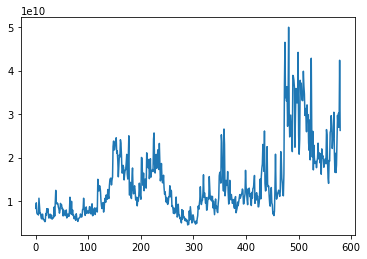

Crypto


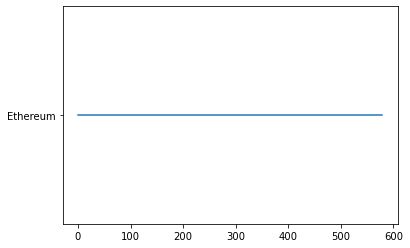

In [5]:
### traitement des  valeurs aberrantes
# 2 solutions :
# - étudier distribution avec boxplot
# - étudier distribution avec nuage de points

def valeurs_aberrantes(df):
    for i in df.columns:
        plt.close()
        print(i)
        plt.plot(df[i])
        plt.show()

valeurs_aberrantes(data_bit)
valeurs_aberrantes(data_eth)

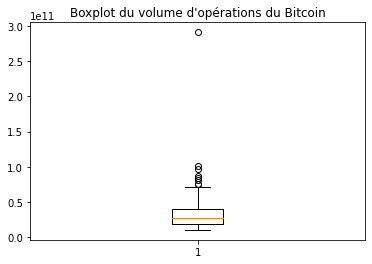

,Date,Open,High,Low,Close,Adj Close,Volume,Crypto
527,2021-02-26,38806.402344,40021.40625,36636.480469,38385.910156,38385.910156,2.907271e+11,Bitcoin


In [6]:
### Une valeur aberrante observée pour le volume d'opération du Bitcoin :
plt.boxplot(data_bit["Volume"])
plt.title("Boxplot du volume d'opérations du Bitcoin")
plt.show()

data_bit[data_bit["Volume"]==data_bit["Volume"].max()]

# pas de données fiables trouvées pour corroborer cette valeur extrême, ni d'explication historique
# on garde pour l'instant cette valeur puisqu'on utilise peu le volume d'opérations

### Cours du Bitcoin et de l'Ethereum

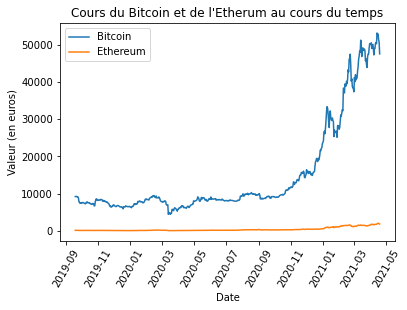

In [7]:
plt.plot(data_bit["Date"],data_bit["Open"],label="Bitcoin")
plt.plot(data_eth["Date"],data_eth["Open"],label="Ethereum")
plt.xticks(rotation=60)
plt.title("Cours du Bitcoin et de l'Etherum au cours du temps")
plt.xlabel("Date")
plt.ylabel("Valeur (en euros)")
plt.legend()
plt.show()

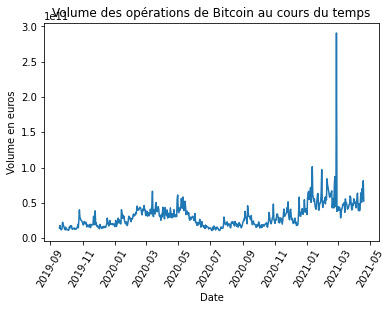

In [8]:
plt.plot(data_bit["Date"],data_bit["Volume"])
plt.xticks(rotation=60)
plt.title("Volume des opérations de Bitcoin au cours du temps")
plt.xlabel("Date")
plt.ylabel("Volume en euros")
plt.show()

## Traitement des données pour pouvoir faire des comparaisons par mois

In [9]:
data_all["Month"] = data_all["Date"].dt.month
data_all["Year"] = data_all["Date"].dt.year

## obtenir les valeurs min et max de chaque mois
minmax_per_month = (
    data_all.groupby(["Crypto", "Month", "Year"], as_index=False)
    .agg({"High":"max", "Low":"min"})
    .rename(columns={"High":"Monthly_high", "Low":"Monthly_low"})
)
data_all = data_all.merge(minmax_per_month, on=["Crypto", "Month", "Year"], how="left")

## obtenir les valeurs d'ouverture et de fermeture de chaque mois
data_all = data_all.sort_values(["Crypto","Date"])
open_month = data_all.groupby(["Crypto", "Month", "Year"], as_index=False).agg({"Open":"first"}).rename(columns={"Open":"Open_month"})
close_month = data_all.groupby(["Crypto", "Month", "Year"], as_index=False).agg({"Close":"last"}).rename(columns={"Close":"Close_month"})
data_all = data_all.merge(open_month, on=["Crypto", "Month", "Year"], how="left")
data_all = data_all.merge(close_month, on=["Crypto", "Month", "Year"], how="left")

### Cours du bitcoin par mois

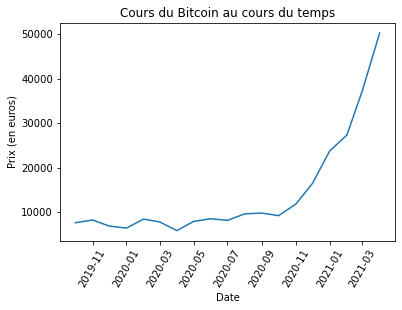

In [10]:
data_to_use = data_all[(data_all["Crypto"] == "Bitcoin") & (data_all["Date"].dt.day == 1)]
data_to_use
plt.plot(data_to_use["Date"],data_to_use["Open_month"])
plt.xticks(rotation=60)
plt.title("Cours du Bitcoin au cours du temps")
plt.xlabel("Date")
plt.ylabel("Prix (en euros)")
plt.show()

## Calcul des variations de la valeur de la crypto par période (jour/mois)

In [11]:
def change_per_day(df):
    df["day_change"] = df["Close"] - df["Open"]
    df["abs_day_change"] = abs(df["day_change"])
    df["Change_sign"] = np.where(df["day_change"]>0,"+","-")
    df["day_max_change"] = df["High"] - df["Low"]
    df["day_change_pct"] = df["day_change"] / df["Open"] * 100
    df["abs_day_change_pct"] = df["abs_day_change"] / df["Open"] * 100
    df["day_max_change_pct"] = df["day_max_change"] / df["Open"] * 100
    return(df)

def change_per_month(df):
    df["month_change"] = df["Close_month"] - df["Open_month"]
    df["abs_month_change"] = abs(df["month_change"])
    df["Change_sign"] = np.where(df["month_change"]>0,"+","-")
    df["month_max_change"] = df["Monthly_high"] - df["Monthly_low"]
    df["month_change_pct"] = df["month_change"] / df["Open_month"] * 100
    df["abs_month_change_pct"] = df["abs_month_change"] / df["Open"] * 100
    df["month_max_change_pct"] = df["month_max_change"] / df["Open_month"] * 100
    return(df)

In [12]:
def all_statistics(df, crypto, month_or_day):
    df = df[df["Crypto"]==crypto]
    if month_or_day == "month":
        return df[["month_change", "month_change_pct", "month_max_change", "month_max_change_pct"]].describe()
    if month_or_day == "day":
        return df[["day_change", "day_change_pct", "day_max_change", "day_max_change_pct"]].describe()

data_all = change_per_day(data_all)
data_all = change_per_month(data_all)
all_statistics(data_all, "Ethereum", "day")

,day_change,day_change_pct,day_max_change,day_max_change_pct
count,576.000000,576.000000,576.000000,576.000000
mean,2.727933,0.503673,32.140905,6.073551
std,32.513947,4.934215,46.825804,4.470451
min,-219.405151,-41.910111,1.288513,0.645170
25%,-3.934731,-1.744904,6.178230,3.205473
50%,0.551902,0.234913,11.892517,4.894562
75%,7.660621,2.673311,31.849846,7.658447
max,158.082764,24.768290,329.747315,42.674166


## Calcul des 10 plus importantes variations périodiques

In [13]:
def top_10_changes(df,month_or_day, crypto, pct, asc_or_desc):
    df = df[df["Crypto"]==crypto]
    if month_or_day == "month":
        df = df[df["Date"].dt.day==1]
        if pct:
            return(df.sort_values("month_change_pct", ascending=asc_or_desc)[["Month","Year","month_change_pct","Crypto"]][:10])
        else:
            return(df.sort_values("month_change", ascending=asc_or_desc)[["Month","Year","month_change","Crypto"]][:10])
    elif month_or_day == "day":
        if pct:
            return(df.sort_values("day_change_pct", ascending=asc_or_desc)[["Date","day_change_pct","Crypto"]][:10])
        else:
            return(df.sort_values("day_change", ascending=asc_or_desc)[["Date","day_change","Crypto"]][:10])
        
top_10_changes(data_all,"day","Bitcoin",True, False)
# data_bit.sort_values("Day_change", ascending=False)[["Date","Day_change","Crypto"]][:10]

,Date,day_change_pct,Crypto
183,2020-03-19,21.338760,Bitcoin
505,2021-02-08,18.760132,Bitcoin
37,2019-10-25,15.864403,Bitcoin
223,2020-04-29,12.282134,Bitcoin
177,2020-03-13,11.309559,Bitcoin
479,2021-01-13,10.450480,Bitcoin
526,2021-03-01,10.285585,Bitcoin
312,2020-07-27,9.889369,Bitcoin
91,2019-12-18,9.818092,Bitcoin
194,2020-03-30,9.621599,Bitcoin


## Etude de la volatilité par période sur différents critères

In [14]:
comparing_day = data_all.groupby("Crypto", as_index=False).agg({"day_change_pct":["mean","std","min","max"],
                                                                "abs_day_change_pct":["mean","std","min","max"],
                                                                "day_max_change_pct":["mean","std","min","max"]})

comparing_month = data_all[data_all["Date"].dt.day==1].groupby("Crypto", as_index=False).agg({"month_change_pct":["mean","std","min","max"],
                                                                                              "abs_month_change_pct":["mean","std","min","max"],
                                                                                              "month_max_change_pct":["mean","std","min","max"]})

comparing_tot = comparing_day.merge(comparing_month, on="Crypto", how="left")
comparing_tot

C:\Users\Mathilde Niay\anaconda3bis\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Crypto day_change_pct                                abs_day_change_pct  \
                      mean       std        min       max               mean   
0   Bitcoin       0.341092  3.830289 -36.752763  21.33876           2.435378   
1  Ethereum       0.503673  4.934215 -41.910111  24.76829           3.305402   

                                 day_max_change_pct  ... month_change_pct  \
        std       min        max               mean  ...              min   
0  2.974270  0.002647  36.752763           4.594486  ...       -25.120687   
1  3.695392  0.009034  41.910111           6.073551  ...       -39.199804   

             abs_month_change_pct                                  \
         max                 mean        std       min        max   
0  44.352699            19.668511  14.015014  1.792983  44.352699   
1  79.618109            26.840498  21.506527  0.267592  79.618109   

  month_max_change_pct                                    
                  mean        std        min         max  
0            34.059298  17.993782  11.103845   78.463529  
1            44.180537  22.473562  14.592456  102.045513  

[2 rows x 25 columns]

# Création de dashboards interactifs

## Premier dashboard : Analyse des données historiques et des plus importantes variations

In [16]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']


app = dash.Dash(__name__, external_stylesheets=external_stylesheets)
app.title = "Analyse des données historiques du Bitcoin et de l'Ethereum"

app.layout = html.Div([
    html.H1("Analyse des données historiques du Bitcoin et de l'Ethereum"),
    html.Div([
    html.Div([
    html.Div([
        html.Div([
            html.Div(children="Cryptomonnaie", className="menu-title"),
            dcc.Dropdown(
                id = "btc-or-eth",
                options=[{"label": crypto, "value": crypto} for crypto in ["Bitcoin", "Ethereum"]],
                value="Bitcoin",
                
            )
        ],style={'width':'35%', 'display':'inline_block', 'margin-right': '1em'},
        ),
        html.Div([
            html.Div(children="Dates",className="menu-title"),
            dcc.DatePickerRange(
                id="date-range",
                min_date_allowed=data_all.Date.min().date(),
                max_date_allowed=data_all.Date.max().date(),
                start_date=data_all.Date.min().date(),
                end_date=data_all.Date.max().date(),
            )
        ]
        )
    ], style = {'display':'flex'},
    ),
    html.Div([
        html.Div([
            html.Div(children="Type de variation", className="menu-title"),
            dcc.Dropdown(
                id = "change-type",
                options = [{"label":"Variation par période", "value":"change"},
                            {"label":"Variation entre plus forte et plus basse valeur", "value":"max_change"}],
                value="change",
                style={'width':'100%', 'display':'inline_block', 'margin-right': '2em'},
            )
        ]
        ),
        html.Div([
            html.Div(children="Relative ou Absolue", className="menu-title"),
            dcc.Dropdown(
                id = "change-type-pct",
                options = [{"label":"Variation absolue en nombre", "value":""},
                            {"label":"Variation relative en %", "value":"_pct"}],
                value="_pct",
                style={'width':'100%', 'display':'inline_block', 'margin-right': '2em'},
            ),
            
        ]
        )
    ],
#         style = {'display':'flex'}
    ),
    html.Div([
        html.Div([
            html.Div(children="Temporalité", className="menu-title"),
            dcc.Dropdown(
                id = "month-or-day",
                options = [{"label":"Par jour", "value":"day_"},
                            {"label":"Par mois", "value":"month_"}],
                value="day_",
                style={'width':'100%', 'display':'inline_block', 'margin-right': '2em'},
            )
        ]
        ),
        html.Div([
            html.Div(children="Positive ou négative", className="menu-title"),
            dcc.Dropdown(
                id = "asc-or-desc",
                options = [{"label":"Variation positive", "value":False},
                            {"label":"Variation négative", "value":True}],
                value=False,
                style={'width':'100%', 'display':'inline_block', 'margin-right': '2em'},
            )
        ]
        )
    ], 
#         style={'display':'flex'}
    )
    ]),
    dcc.Graph(id="plot-price", style={'margin-left':'10em'})
    ], style={'display':'flex'}),
    html.Div([
        dcc.Graph(id="bar-graph", style={'display': 'inline-block'}),
        dcc.Graph(id="plot-volume", style={'display': 'inline-block'})
    ], style={'display':'flex'}),
])

@app.callback(
    dash.dependencies.Output('plot-price', 'figure'),
    [dash.dependencies.Input('btc-or-eth', 'value'), 
     dash.dependencies.Input('date-range', 'start_date'),
     dash.dependencies.Input('date-range', 'end_date'),
     dash.dependencies.Input('month-or-day', 'value')])

def update_graphs_price(crypto_type, start_date, end_date, month_or_day):
    data_to_use = data_all[data_all["Crypto"]==crypto_type]
    data_to_use = data_to_use[(data_to_use["Date"]>=start_date) & (data_to_use["Date"]<=end_date)]
    if month_or_day=="month_":
        data_to_use = data_to_use[data_to_use["Date"].dt.day==1]
    figure={
                "data": [
                    {
                        "x": data_to_use["Date"],
                        "y": data_to_use["Open"],
                        "type": "lines",
                    },
                ],
                "layout": {"title": "Evolution du cours de la crypto",
                           "height":"400",
                           "yaxis":{"title":"Valeur en euros"}},
            }
    return(figure)

@app.callback(
    dash.dependencies.Output('plot-volume', 'figure'),
    [dash.dependencies.Input('btc-or-eth', 'value'), 
     dash.dependencies.Input('date-range', 'start_date'),
     dash.dependencies.Input('date-range', 'end_date'),
     dash.dependencies.Input('month-or-day', 'value')])

def update_graph_volume(crypto_type, start_date, end_date, month_or_day):
    data_to_use = data_all[data_all["Crypto"]==crypto_type]
    data_to_use = data_to_use[(data_to_use["Date"]>=start_date) & (data_to_use["Date"]<=end_date)]
    if month_or_day=="month_":
        data_to_use = data_to_use[data_to_use["Date"].dt.day==1]
    figure={
                "data": [
                    {
                        "x": data_to_use["Date"],
                        "y": data_to_use["Volume"],
                        "type": "lines",
                    },
                ],
                "layout": {"title": "Evolution du volume d'opérations",
                           "yaxis": {"title":"Volume en euros"}},
            }      
    return(figure)


@app.callback(
    dash.dependencies.Output('bar-graph', 'figure'),
    [dash.dependencies.Input('btc-or-eth', 'value'),
     dash.dependencies.Input('date-range', 'start_date'),
     dash.dependencies.Input('date-range', 'end_date'),
     dash.dependencies.Input('change-type', 'value'),
     dash.dependencies.Input('change-type-pct', 'value'),
     dash.dependencies.Input('month-or-day', 'value'),
     dash.dependencies.Input('asc-or-desc', 'value')])

def create_bar_plot(crypto_type, start_date, end_date, change_type, change_type_pct, month_or_day, asc_or_desc):
    data_to_use = data_all[data_all["Crypto"]==crypto_type]
    data_to_use = data_to_use[(data_to_use["Date"]>=start_date) & (data_to_use["Date"]<=end_date)]

    if month_or_day == "month_":
        data_to_use = data_to_use[data_to_use["Date"].dt.day==1]
    var_name = month_or_day + change_type + change_type_pct
    data_to_use = data_to_use.sort_values(var_name, ascending=asc_or_desc)[["Date",var_name,"Crypto"]][:10]
    data_to_use["Date"] = data_to_use["Date"].astype(str)
    if change_type_pct == "_pct":
        y_label = "Pct de variation"
    else:
        y_label = "Valeur"
    barchart = px.bar(x=data_to_use["Date"], y=data_to_use[var_name],
                      labels = {"x":"Date", "y":y_label},
                      title = "Périodes où les variations ont été les plus importantes")
    return(barchart)
    
if __name__ == '__main__':
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)


## Second dashboard : Comparaison de la volatilité entre Bitcoin et Ethereum

In [17]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']


app = dash.Dash(__name__, external_stylesheets=external_stylesheets)
server = app.server

app.title = "Comparaison de la volatilité du Bitcoin et de l'Ethereum"

app.layout = html.Div([
    html.H1("Comparaison de la volatilité du Bitcoin et de l'Ethereum"),
    html.Div([
        html.Div([
            html.Div(children="Dates",className="menu-title"),
            dcc.DatePickerRange(
                id="date-range",
                min_date_allowed=data_all.Date.min().date(),
                max_date_allowed=data_all.Date.max().date(),
                start_date=data_all.Date.min().date(),
                end_date=data_all.Date.max().date(),
            )
        ]
        )
    ], style = {'display':'flex'},
    ),
    html.Div([
        html.Div([
            html.Div(children="Type de variation", className="menu-title"),
            dcc.Dropdown(
                id = "change-type",
                options = [{"label":"Variation par période", "value":"change"},
                            {"label":"Variation entre plus forte et plus basse valeur", "value":"max_change"}],
                value="change",
                style={'width':'64%', 'display':'inline_block', 'margin-right': '2em'},
            )
        ]
        ),
        html.Div([
            html.Div(children="Relative ou Absolue", className="menu-title"),
            dcc.Dropdown(
                id = "change-type-pct",
                options = [{"label":"Variation absolue en nombre", "value":""},
                            {"label":"Variation relative en %", "value":"_pct"}],
                value="_pct",
                style={'width':'64%', 'display':'inline_block', 'margin-right': '2em'},
            )
        ]
        )
    ],
#         style = {'display':'flex'}
    ),
    html.Div([
        html.Div([
            html.Div(children="Temporalité", className="menu-title"),
            dcc.Dropdown(
                id = "month-or-day",
                options = [{"label":"Par jour", "value":"day_"},
                            {"label":"Par mois", "value":"month_"}],
                value="day_",
                style={'width':'64%', 'display':'inline_block', 'margin-right': '2em'},
            )
        ]
        ),
    ], 
    ),
    html.Div([
        html.H2("BITCOIN"),
        html.Div([
            html.Div([
                html.H3("Moyenne"), 
                html.H3(id="moyenne-bit"),
            ],
            style={'width': '20%', 'display': 'inline-block', 'border': '2px solid black', 'text-align': 'center', 'font-family': 'Century Gothic'}),
            html.Div([
                html.H3("Ecart-type"), 
                html.H3(id="std-bit"),
            ],
            style={'width': '20%', 'display': 'inline-block', 'border': '2px solid black', 'text-align': 'center', 'font-family': 'Century Gothic'}),
            html.Div([
                html.H3("Min"), 
                html.H3(id="min-bit"),
            ],
            style={'width': '20%', 'display': 'inline-block', 'border': '2px solid black', 'text-align': 'center', 'font-family': 'Century Gothic'}),
            html.Div([
                html.H3("Max"), 
                html.H3(id="max-bit"),
            ],
            style={'width': '20%', 'display': 'inline-block', 'border': '2px solid black', 'text-align': 'center', 'font-family': 'Century Gothic'})         

        ], style={'width': '70%','display': 'inline-block', 'vertical-align' : 'top', 'font-family' : 'Century Gothic'})
    ]),
    html.Div([
        html.H2("ETHEREUM"),
        html.Div([
            html.Div([
                html.H3("Moyenne"), 
                html.H3(id="moyenne-eth"),
            ],
            style={'width': '20%', 'display': 'inline-block', 'border': '2px solid black', 'text-align': 'center', 'font-family': 'Century Gothic'}),
            html.Div([
                html.H3("Ecart-type"), 
                html.H3(id="std-eth"),
            ],
            style={'width': '20%', 'display': 'inline-block', 'border': '2px solid black', 'text-align': 'center', 'font-family': 'Century Gothic'}),
            html.Div([
                html.H3("Min"), 
                html.H3(id="min-eth"),
            ],
            style={'width': '20%', 'display': 'inline-block', 'border': '2px solid black', 'text-align': 'center', 'font-family': 'Century Gothic'}),
            html.Div([
                html.H3("Max"), 
                html.H3(id="max-eth"),
            ],
            style={'width': '20%', 'display': 'inline-block', 'border': '2px solid black', 'text-align': 'center', 'font-family': 'Century Gothic'})

        ], style={'width': '70%','display': 'inline-block', 'vertical-align' : 'top', 'font-family' : 'Century Gothic'})
    ]),
    html.Div(
        dcc.Graph(id='variation-graph')
    )    
])




@app.callback(
    dash.dependencies.Output('moyenne-bit', 'children'),
    [dash.dependencies.Input('date-range', 'start_date'),
     dash.dependencies.Input('date-range', 'end_date'),
     dash.dependencies.Input('change-type', 'value'),
     dash.dependencies.Input('change-type-pct', 'value'),
     dash.dependencies.Input('month-or-day', 'value')])

def update_comparing_mean(start_date, end_date, change_type, change_type_pct, month_or_day):
    data_to_use = data_all[data_all["Crypto"]=="Bitcoin"]
    data_to_use = data_to_use[(data_to_use["Date"]>=start_date) & (data_to_use["Date"]<=end_date)]
    if month_or_day == "month_":
        data_to_use = data_to_use[data_to_use["Date"].dt.day==1]
    var_name = month_or_day + change_type + change_type_pct
    input_value = round(data_to_use[var_name].mean(),4)
    return input_value

@app.callback(
    dash.dependencies.Output('std-bit', 'children'),
    [dash.dependencies.Input('date-range', 'start_date'),
     dash.dependencies.Input('date-range', 'end_date'),
     dash.dependencies.Input('change-type', 'value'),
     dash.dependencies.Input('change-type-pct', 'value'),
     dash.dependencies.Input('month-or-day', 'value')])

def update_comparing_std(start_date, end_date, change_type, change_type_pct, month_or_day):
    data_to_use = data_all[data_all["Crypto"]=="Bitcoin"]
    data_to_use = data_to_use[(data_to_use["Date"]>=start_date) & (data_to_use["Date"]<=end_date)]
    if month_or_day == "month_":
        data_to_use = data_to_use[data_to_use["Date"].dt.day==1]
    var_name = month_or_day + change_type + change_type_pct
    input_value = round(data_to_use[var_name].std(),4)
    return input_value

@app.callback(
    dash.dependencies.Output('min-bit', 'children'),
    [dash.dependencies.Input('date-range', 'start_date'),
     dash.dependencies.Input('date-range', 'end_date'),
     dash.dependencies.Input('change-type', 'value'),
     dash.dependencies.Input('change-type-pct', 'value'),
     dash.dependencies.Input('month-or-day', 'value')])

def update_comparing_min(start_date, end_date, change_type, change_type_pct, month_or_day):
    data_to_use = data_all[data_all["Crypto"]=="Bitcoin"]
    data_to_use = data_to_use[(data_to_use["Date"]>=start_date) & (data_to_use["Date"]<=end_date)]
    if month_or_day == "month_":
        data_to_use = data_to_use[data_to_use["Date"].dt.day==1]
    var_name = month_or_day + change_type + change_type_pct
    input_value = round(data_to_use[var_name].min(),4)
    return input_value

@app.callback(
    dash.dependencies.Output('max-bit', 'children'),
    [dash.dependencies.Input('date-range', 'start_date'),
     dash.dependencies.Input('date-range', 'end_date'),
     dash.dependencies.Input('change-type', 'value'),
     dash.dependencies.Input('change-type-pct', 'value'),
     dash.dependencies.Input('month-or-day', 'value')])

def update_comparing_max(start_date, end_date, change_type, change_type_pct, month_or_day):
    data_to_use = data_all[data_all["Crypto"]=="Bitcoin"]
    data_to_use = data_to_use[(data_to_use["Date"]>=start_date) & (data_to_use["Date"]<=end_date)]
    if month_or_day == "month_":
        data_to_use = data_to_use[data_to_use["Date"].dt.day==1]
    var_name = month_or_day + change_type + change_type_pct
    input_value = round(data_to_use[var_name].max(),4)
    return input_value


@app.callback(
    dash.dependencies.Output('moyenne-eth', 'children'),
    [dash.dependencies.Input('date-range', 'start_date'),
     dash.dependencies.Input('date-range', 'end_date'),
     dash.dependencies.Input('change-type', 'value'),
     dash.dependencies.Input('change-type-pct', 'value'),
     dash.dependencies.Input('month-or-day', 'value')])

def update_comparing_mean_bis(start_date, end_date, change_type, change_type_pct, month_or_day):
    data_to_use = data_all[data_all["Crypto"]=="Ethereum"]
    data_to_use = data_to_use[(data_to_use["Date"]>=start_date) & (data_to_use["Date"]<=end_date)]
    if month_or_day == "month_":
        data_to_use = data_to_use[data_to_use["Date"].dt.day==1]
    var_name = month_or_day + change_type + change_type_pct
    input_value = round(data_to_use[var_name].mean(),4)
    return input_value

@app.callback(
    dash.dependencies.Output('std-eth', 'children'),
    [dash.dependencies.Input('date-range', 'start_date'),
     dash.dependencies.Input('date-range', 'end_date'),
     dash.dependencies.Input('change-type', 'value'),
     dash.dependencies.Input('change-type-pct', 'value'),
     dash.dependencies.Input('month-or-day', 'value')])

def update_comparing_std(start_date, end_date, change_type, change_type_pct, month_or_day):
    data_to_use = data_all[data_all["Crypto"]=="Ethereum"]
    data_to_use = data_to_use[(data_to_use["Date"]>=start_date) & (data_to_use["Date"]<=end_date)]
    if month_or_day == "month_":
        data_to_use = data_to_use[data_to_use["Date"].dt.day==1]
    var_name = month_or_day + change_type + change_type_pct
    input_value = round(data_to_use[var_name].std(),4)
    return input_value

@app.callback(
    dash.dependencies.Output('min-eth', 'children'),
    [dash.dependencies.Input('date-range', 'start_date'),
     dash.dependencies.Input('date-range', 'end_date'),
     dash.dependencies.Input('change-type', 'value'),
     dash.dependencies.Input('change-type-pct', 'value'),
     dash.dependencies.Input('month-or-day', 'value')])

def update_comparing_min_bis(start_date, end_date, change_type, change_type_pct, month_or_day):
    data_to_use = data_all[data_all["Crypto"]=="Ethereum"]
    data_to_use = data_to_use[(data_to_use["Date"]>=start_date) & (data_to_use["Date"]<=end_date)]
    if month_or_day == "month_":
        data_to_use = data_to_use[data_to_use["Date"].dt.day==1]
    var_name = month_or_day + change_type + change_type_pct
    input_value = round(data_to_use[var_name].min(),4)
    return input_value

@app.callback(
    dash.dependencies.Output('max-eth', 'children'),
    [dash.dependencies.Input('date-range', 'start_date'),
     dash.dependencies.Input('date-range', 'end_date'),
     dash.dependencies.Input('change-type', 'value'),
     dash.dependencies.Input('change-type-pct', 'value'),
     dash.dependencies.Input('month-or-day', 'value')])

def update_comparing_max_bis(start_date, end_date, change_type, change_type_pct, month_or_day):
    data_to_use = data_all[data_all["Crypto"]=="Ethereum"]
    data_to_use = data_to_use[(data_to_use["Date"]>=start_date) & (data_to_use["Date"]<=end_date)]
    if month_or_day == "month_":
        data_to_use = data_to_use[data_to_use["Date"].dt.day==1]
    var_name = month_or_day + change_type + change_type_pct
    input_value = round(data_to_use[var_name].max(),4)
    return input_value


@app.callback(
    dash.dependencies.Output('variation-graph', 'figure'),
    [dash.dependencies.Input('date-range', 'start_date'),
     dash.dependencies.Input('date-range', 'end_date'),
     dash.dependencies.Input('change-type', 'value'),
     dash.dependencies.Input('change-type-pct', 'value'),
     dash.dependencies.Input('month-or-day', 'value')])
    
def update_graph(start_date, end_date, change_type, change_type_pct, month_or_day):
    data_to_use = data_all[(data_all["Date"]>=start_date) & (data_all["Date"]<=end_date)]
    if month_or_day == "month_":
        data_to_use = data_to_use[data_to_use["Date"].dt.day==1]
    var_name = month_or_day + change_type + change_type_pct
    values = []
    cryptos = []
    times = []
    for i in ["Bitcoin", "Ethereum"]:
        data_to_use_aux = data_to_use[data_to_use["Crypto"]==i]
        values += list(data_to_use_aux[var_name])
        cryptos += [i]*len(data_to_use_aux)
        times += list(data_to_use_aux["Date"])
    if change_type_pct == "_pct":
        y_label = "Variation en pct"
    else:
        y_label = "Variation en valeur"
    fig = px.line(dict(Cryptos=cryptos, values=values, Date=times), x='Date', y='values', color='Cryptos',
                  labels = {"values" : y_label})
#     fig.update_traces(mode='markers+lines')
#     fig.show()
#     figure={
#                 "data": [
#                     {
#                         "x": times,
#                         "y": values,
#                         "type": "lines",
#                     },
#                 ],
#                 "layout": {"title": "Evolution du nombre d'opérations"},
#             }
    return(fig)

if __name__ == '__main__':
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [26/Apr/2021 13:29:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Apr/2021 13:29:55] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [26/Apr/2021 13:29:55] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [26/Apr/2021 13:29:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [26/Apr/2021 13:29:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [26/Apr/2021 13:29:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [26/Apr/2021 13:29:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [26/Apr/2021 13:29:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [26/Apr/2021 13:29:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [26/Apr/2021 13:29:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [26/Apr/2021 13:29:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [26/Apr/2021 13:29:55] "POST /_dash-update-component